# Trabajo Práctico 2 : NLP + Árboles de Decisión

Fecha máxima de entrega: *Lunes 30 de mayo.*

---



In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import io
from math import pi
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, make_scorer
from sklearn.neighbors import LocalOutlierFactor

## Análisis de sentimientos

En esta primera parte se trabajará sobre un conjunto de datos de comercio electrónico de ropa de mujer que contiene reseñas escritas por los clientes. El objetivo es realizar un análisis de sentimientos para clasificar las reseñas como positivas o negativas.


### Exploración, preprocesamiento y transformación de datos


#### Exploración del dataset

Este dataset tiene 10 variables distintas, en donde cada fila presenta una crítica (positiva o negativa) a una prenda de ropa.

| _Variable_              	| _Tipo_                	| _Descripción_                                                   	|
|-------------------------	|-----------------------	|-----------------------------------------------------------------	|
| Clothing ID             	| Cualitativa nominal	| ID de la prenda                                                 	|
| Age                     	| Cuantitativa continua 	| Edad de la persona que hace la crítica                          	|
| Title                   	| Cualitativa nominal   	| Título de la crítica                                            	|
| Review Text             	| Cualitativa           	| Texto de la crítica                                             	|
| Rating                  	| Cuantitativa discreta 	| Puntuación de 1 a 5                                             	|
| Recommended IND         	| Cualitativa binaria   	| Si el cliente lo recomienda (1) o no (0)	|
| Positive Feedback Count 	| Cuantitativa discreta 	| La cantidad de otros clientes que encuentran a la cŕitica como buena |
| Division Name           	| Cualitativa nominal   	| División a la que pertenece la prenda                           	|
| Department Name         	| Cualitativa nominal   	| Departamento (dentro de la división) al que pertenece la prenda 	|
| Class Name              	| Cualitativa nominal   	| Clase (dentro del departamento) a la que pertenece la prenda    	|

In [154]:
data = pd.read_csv('../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')
data

Como hay una columna que duplica los índices la eliminamos.

In [155]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data

Sobre las variables cualitativas, vemos para _Division Name_ y _Department Name_ la cantidad de registros sobre cada una.

In [156]:
colores = sns.color_palette("inferno_r", 3)
data['Division Name'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8), title='Cantidad de registros por División')
plt.show()

In [157]:
fig, axarr=plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
data[data['Division Name']=='General']['Department Name'].value_counts().plot.bar(title='General', color=sns.color_palette("inferno_r", 5), ax=axarr[0])
data[data['Division Name']=='General Petite']['Department Name'].value_counts().plot.bar(title='General Petite', color=sns.color_palette("inferno_r", 6), ax=axarr[1])
data[data['Division Name']=='Initmates']['Department Name'].value_counts().plot.bar(title='Initmates', color=sns.color_palette("inferno_r", 1), ax=axarr[2])
plt.show()

Respecto a _Class Name_ hacemos una suma de la cantidad de apariciones agrupado por departamento y división.

In [158]:
data.groupby(['Division Name', 'Department Name'])['Class Name'].value_counts()

Para las variables cuantitavivas realizamos un histograma para la variable _Age_ y uno gráfico de barras para _Rating_.

In [159]:
data['Age'].plot.hist(bins=20, figsize=(15,8), color=['#BA3655']).set_title('Histograma para la variable Age')
plt.show()

In [160]:
ax = data['Clothing ID'].value_counts().sort_values(ascending=False).head(5).plot.bar(figsize=(15,8), color=['#FF336A'])
ax.set_title('Top 5 prendas con mas reviews')
plt.show()

#### Limpieza y transformación

##### Comenzamos por las variables cuantitativas



Vemos la cantidad de valores nulos (NaN) en el dataset.

In [161]:
data.isna().sum()

Para éste tipo de variable no hay datos nulos, revisamos que no haya datos nulos (distintos de NaN, como 0 por ejemplo) u outliers. Para eso vemos las medidas de resumen de las variables cuantitativas del dataset.

In [162]:
cuantitativas = data[['Age', 'Rating', 'Positive Feedback Count']]
cuantitativas.describe()

Por el lado de los valores mínimos no se ve nada raro, por el lado de los máximos sí. Para sacar los outliers vamos a realizar un análisis univariado calculando el z_score.

In [163]:
# z_score edad
data['z_Age']=st.zscore(data.Age)

# z_score modificado Rating
data['z_Rating']=st.zscore(data.Rating)

# z_score modificado Positive Feedback Count
data.rename(columns={'Positive Feedback Count':'Positive_Feedback_Count'}, inplace=True)
data['z_PFC']=st.zscore(data.Positive_Feedback_Count)

data[['Age', 'Rating', 'Positive_Feedback_Count', 'z_Age', 'z_Rating', 'z_PFC']]

In [164]:
sns.boxplot(y=data['Age'])

In [165]:
sns.boxplot(y=data['Rating'])

In [166]:
data['Rating'].value_counts()

In [167]:
sns.boxplot(y=data['Positive_Feedback_Count'])

Verifico para cada variable que `abs(z_score) < 3`. Revisamos los outliers para cada variable.



In [168]:
data[abs(data['z_Age']) >= 3][['Age', 'z_Age']].sort_values(by='z_Age', ascending=False)

In [169]:
data[abs(data['z_Rating']) >= 3][['Rating', 'z_Rating']]

In [170]:
data[abs(data['z_PFC']) >= 3][['Positive_Feedback_Count', 'z_PFC']].sort_values(by='Positive_Feedback_Count', ascending=False)

El dataset en total tiene 23486 registros, de los cuales 529 (como mucho, ya que puede haber algún repetido entre los outliers de _Age_ y _Positive Feedback Count_) son outliers según el cálculo del z_score, lo que representa sólo un 2.25%. Como la edad y el positive feedback no impactan en la validez de la review, los consideramos para el analisis.

Finalmente, eliminamos las columnas agregadas.

In [171]:
data.drop(columns=['z_Age', 'z_Rating', 'z_PFC'], inplace=True)

##### Seguimos por las cualitativas

Vemos la cantidad de valores nulos (NaN) en el dataset.

In [172]:
data.isna().sum()

Empezamos por llenar la división, departamento y clase.

In [173]:
data.loc[data['Class Name'].isna()]

In [174]:
len(data)

Encontramos 14 registros que no tienen asociado una prenda de vestir (Class name), departamento (Department Name) ni tipo de prenda (Division Name), por lo que no tenemos referencias para llenarlos. Al no ser una cantidad significativa (14 sobre 23 mil) no los vamos a considerar para el analisis.

In [175]:
data.drop(index= data[data['Class Name'].isna()].index, inplace=True)
len(data)

Para los casos en que Title o Review Text son nulos, tampoco los vamos a considerar en el analisis. Si uno de los dos es exclusivamente nulo, reemplazamos el valor NaN con su variante no nula. 

In [176]:
len(data[(data['Title'].isna()) & (data['Review Text'].isna())])

In [177]:
data.drop(index= data[(data['Title'].isna()) & (data['Review Text'].isna())].index, inplace=True)
len(data)

In [178]:
data['Review Text'].fillna(data['Title'], inplace=True)
data['Title'].fillna(data['Review Text'], inplace=True)

In [179]:
data.loc[data['Review Text'].str.len().sort_values().index]

Observamos que las Review Text son reseñas validas para cada prenda, y en donde el Title o el Review Text eran nulos, se reemplazo por su contraparte no nula.

In [180]:
data.loc[data['Title'].str.len().sort_values().index]

Observamos tambien que los titulos con pocos caracteres, corresponden a reseñas validas para cada prenda.

In [181]:
data['Clothing ID'].value_counts()

In [182]:
data.isna().sum()

#### Construccion de variable objetivo en funcion del Rating

Construimos la variable a analizar en base al Rating, donde los ratings entre 1-3 van a ser reviews negativas y entre 4-5 reviews positivas. Llamamos a nuestra variable objetivo _Positive_review_ que toma valores 0 (review negativa) y 1 (review positiva).

In [183]:
data['Positive_review'] = data['Rating']
data.loc[data['Rating'] < 4, 'Positive_review'] = 0
data.loc[data['Rating'] >= 4, 'Positive_review'] = 1

data[['Rating', 'Positive_review']]

In [184]:
data.value_counts(['Positive_review'])

### Generación y evaluación de modelos 

#### Generacion de conjunto de prueba y conjunto de entrenamiento

Separamos el dataset original en dos subsets, donde uno representa el 70% de los registros que van a ser utilizados para entrenar el modelo y el otro 30% restante se utilizara para prueba.

In [185]:
data_cpy = data.copy()
data_cpy.rename(columns={'Review Text':'Review_Text'}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_cpy.Review_Text, data_cpy.Positive_review, test_size=0.30, random_state=25, shuffle=True)


In [186]:
y_train.value_counts()

In [187]:
y_test.value_counts()

Dado que las reviews están en formato texto, transformamos al set para poder trabajar con los distintos modelos.

In [188]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
corpus = vectorizer.get_feature_names_out()

transformer = TfidfTransformer(smooth_idf=True)
transformer.fit_transform(X.toarray()).toarray()

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

#### Generacion de modelos

A continuacion generamos los siguientes modelos:



 * Naive Bayes
 * Regresión logística
 * Árboles de decisión
 * Random Forest  



##### Naive bayes

Sin hiperparámetros

In [189]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(X_train, y_train)

predicted_categories = model.predict(X_test)

nb_acc_paramless = accuracy_score(y_test, predicted_categories)
nb_recall_paramless = recall_score(y_test, predicted_categories)
nb_f1_paramless = f1_score(y_test, predicted_categories)

print("La precision es {}".format(nb_acc_paramless))

print("El recall es {}".format(nb_recall_paramless))

print("F1 es {}".format(nb_f1_paramless))

Con hiperparámetros

In [190]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=0.005))

model.fit(X_train, y_train)

predicted_categories = model.predict(X_test)

nb_acc = accuracy_score(y_test, predicted_categories)
nb_recall = recall_score(y_test, predicted_categories)
nb_f1 = f1_score(y_test, predicted_categories)

print("La precision es {}".format(nb_acc))

print("El recall es {}".format(nb_recall))

print("F1 es {}".format(nb_f1))


Realizamos una gráfica copmarativa

In [191]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [nb_acc, nb_acc_paramless],
'Recall': [nb_recall, nb_recall_paramless],
'F1': [nb_f1, nb_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=7)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="NB con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="NB sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

Se puede ver que el Naive Bayes que mejor predice es el que tiene hiperparámetros.

##### Regresión logística

Regresión logística con hiperparámetros.

In [192]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(penalty="l1", solver="liblinear"))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories_positive = model.predict(X_test)

lr_acc = accuracy_score(y_test, predicted_categories_positive)
lr_recall = recall_score(y_test, predicted_categories_positive, average="weighted")
lr_f1 = f1_score(y_test, predicted_categories_positive, average="weighted")

print("La precision es {}".format(lr_acc))

print("El recall es {}".format(lr_recall))

print("F1 es {}".format(lr_f1))

Regresión logística modificando la cantidad de iteraciones máxima.

In [193]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter = 300))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

lr_acc_paramless = accuracy_score(y_test, predicted_categories)
lr_recall_paramless = recall_score(y_test, predicted_categories, average="weighted")
lr_f1_paramless = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(lr_acc_paramless))

print("El recall es {}".format(lr_recall_paramless))

print("F1 es {}".format(lr_f1_paramless))

In [194]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [lr_acc, lr_acc_paramless],
'Recall': [lr_recall, lr_recall_paramless],
'F1': [lr_f1, lr_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="LR con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="LR sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

Se puede ver que ambas predicen de una forma muy similar.

##### Árboles de decisión

Creamos un árbol sin hiperparámetros.

In [195]:
model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

dt_acc_paramless = accuracy_score(y_test, predicted_categories)
dt_recall_paramless = recall_score(y_test, predicted_categories, average="weighted")
dt_f1_paramless = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(dt_acc_paramless))

print("El recall es {}".format(dt_recall_paramless))

print("F1 es {}".format(dt_f1_paramless))

Y otro con hiperparámetros.

In [196]:
model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(ccp_alpha=0.001))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

dt_acc = accuracy_score(y_test, predicted_categories)
dt_recall = recall_score(y_test, predicted_categories, average="weighted")
dt_f1 = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(dt_acc))

print("El recall es {}".format(dt_recall))

print("F1 es {}".format(dt_f1))

A continuación comparamos los árboles.

In [197]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [dt_acc, dt_acc_paramless],
'Recall': [dt_recall, dt_recall_paramless],
'F1': [dt_f1, dt_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="DT con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="DT sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

##### Random Forest

Creamos un modelo sin hiperparámetros, el criterio por defecto es _Gini_

In [198]:
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

rf_acc_paramless = accuracy_score(y_test, predicted_categories)
rf_recall_paramless = recall_score(y_test, predicted_categories, average="weighted")
rf_f1_paramless = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(rf_acc_paramless))

print("El recall es {}".format(rf_recall_paramless))

print("F1 es {}".format(rf_f1_paramless))

Cambiamos el criterio por _Entropía_ para el otro modelo.

In [199]:
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier(criterion="entropy"))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

rf_acc = accuracy_score(y_test, predicted_categories)
rf_recall = recall_score(y_test, predicted_categories, average="weighted")
rf_f1 = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(rf_acc))

print("El recall es {}".format(rf_recall))

print("F1 es {}".format(rf_f1))

In [200]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [rf_acc, rf_acc_paramless],
'Recall': [rf_recall, rf_recall_paramless],
'F1': [rf_f1, rf_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

Se puede ver que ambos tienen resultados similares.

#### Analisis de resultados y eleccion de modelo

Seleccionamos los modelos que mejores resultados dieron y los comparamos.

In [201]:
df = pd.DataFrame({
'Modelo': ['Naive Bayes','Regresion Logistica','Arbol de decision','Random Forest'],
'Precision': [nb_acc, lr_acc, dt_acc, rf_acc],
'Recall': [nb_recall, lr_recall, dt_recall, rf_recall],
'F1': [nb_f1, lr_recall, dt_recall, rf_recall]
})
  
def make_spider( row, title, color):

    categories=list(df)[1:]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(2,2,row+1, polar=True, )

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=15)

    ax.set_rlabel_position(0)
    plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
    plt.ylim(0.5,1)

    values=df.loc[row].drop('Modelo').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title(title, size=15, color=color, y=1.1)

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
my_palette = plt.cm.get_cmap("Set1", len(df.index))
 
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['Modelo'][row], color=my_palette(row))

Nos quedamos con el modelo que promedia mejores metricas, regresion logistica, para intentar predecir la calificacion en base a la crítica. Cambiamos los hiperparametros para que ajuste mejor a variables no binarias, como es el caso de la puntuacion.

In [202]:
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(data_cpy.Review_Text, data_cpy.Rating, test_size=0.30, random_state=25, shuffle=True)

vectorizer = CountVectorizer()
X_rating = vectorizer.fit_transform(X_train_rating)
corpus = vectorizer.get_feature_names_out()

transformer = TfidfTransformer(smooth_idf=True)
transformer.fit_transform(X_rating.toarray()).toarray()

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

model = make_pipeline(TfidfVectorizer(), LogisticRegression(solver="sag", multi_class="multinomial"))

model.fit(X_train_rating, y_train_rating)

predicted_categories_rating = model.predict(X_test_rating)

lr_acc_rating = accuracy_score(y_test_rating, predicted_categories_rating)
lr_recall_rating = recall_score(y_test_rating, predicted_categories_rating, average="micro")
lr_f1_rating = f1_score(y_test_rating, predicted_categories_rating, average="micro")

print("La precision es {}".format(lr_acc_rating))

print("El recall es {}".format(lr_recall_rating))

print("F1 es {}".format(lr_f1_rating))

Realizamos un gráfico para comparar los resultados obtenidos al predecir si la review es positiva o negativa y el rating.

In [203]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [lr_acc, lr_acc_rating],
'Recall': [lr_recall, lr_recall_rating],
'F1': [lr_f1, lr_f1_rating],
})

categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF Positive review")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF Rating")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Observamos que su rendimiento fue mucho mas bajo que para *Positive reviews*

### 3. Conclusiones

##### Variable *Positive review*

En cuanto al modelo para la variable binaria *Positive Reviews*, notamos que existe una mala prediccion para las reviews negativas.

Las predicciones negativas tienden a fallar en un 30%, pero al ser aproximadamente un 25% de las reviews, este fallo no llega a apreciarse en el rendimiento del modelo, pero queda en evidencia en la matriz de confusion.

Reducir el dataset original para que el ratio de reviews positivas y negativas sea de 50/50 no consideramos que sea una buena alternativa, ya que se pierden casi la mitad de los registros que se tienen para analizar, por lo que descartamos esa opcion.

In [204]:
y_test.value_counts()

Al ser 3 veces mayor la cantidad de reviews positivas que negativas, el modelo tiende a mejorar las predicciones cuando se trata de reviews positivas.

In [205]:
y_test.value_counts().set_axis(['Positivas', 'Negativas']).plot(kind='pie', title='Reviews', figsize=[7,7])

In [206]:
cf_matrix = pd.crosstab(y_test,predicted_categories_positive)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
plt.xlabel('predicted')

Se puede observar que aproximadamente 1/3 de las reviews negativas fueron mal predichas

In [207]:
neg_reviews = cf_matrix.loc[0].set_axis(['Bien predichas', 'Mal predichas'])
neg_reviews.plot(kind='pie', title='Reviews negativas', figsize=[7,7])

Mientras que las reviews positivas en general fueron bien predichas

In [208]:
pos_reviews = cf_matrix.loc[1].set_axis(['Mal predichas', 'Bien predichas'])
pos_reviews.plot(kind='pie', title='Reviews positivas', figsize=[7,7])

Habiendo considerado lo anterior, no podemos recomendar el uso de los modelos en un entorno productivo, ya que no predice de forma correcta reviews negativas o de puntuaciones de tres estrellas o menos.

##### Variable *Rating*

Se observa una peor prediccion del modelo cuando se cambia la variable a predecir. Por una parte el dataset contiene porcentajes desiguales para cada rating, donde el rating 5 ocupa mas del 50% del dataset, mientras que rating 1 menos del 5%. Se puede ver en la matriz de confusion como el rating 5 fue predicho con mayor exactitud que el resto, y como la desviacion de predicciones con ratings intermedios (2, 3, 4) tambien mejoran su precision si se acepta un error de +- 1.

No recomendamos reducir el dataset para que todos los ratings tengan una cantidad de registros parecida, ya que el rating mas bajo tiene un 5% de las reviews totales. Si queremos equiparar la cantidad de reviews tenemos que reducir el dataset a un 25% de los registros totales, perdiendo asi demasiada informacion.

In [209]:
data_cpy['Rating'].value_counts()

In [210]:
data_cpy['Rating'].value_counts().plot(kind='pie', title='Reviews por puntuacion', figsize=[7,7])

Vemos que existe un sesgo en la informacion, donde la mayoria de reviews son de 5 estrellas, afectando la prediccion de nuestro modelo y solo teniendo buen rendimiento para el rating 5.

In [211]:
cf_matrix = pd.crosstab(y_test_rating,predicted_categories_rating)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
plt.xlabel('predicted')

Por otro lado se observa que para los ratings mas bajos (1, 2) el modelo intenta adivinar a que categoria pertenece.

En consideracion, no recomendamos el modelo creado para un entorno productivo, ya que en general no va a predecir de forma correcta los ratings 1-4.

## Árboles de desición

### Exploracion, preprocesamiento y transformacion de datos

#### Exploracion

En esta segunda parte se trabajará sobre un conjunto de datos de reservas de hotel. El
objetivo es predecir cuál de ellas va a ser cancelada. Para resolver este problema utilizaremos árboles de decisión.

In [212]:
data = pd.read_csv('../input/hotel-booking-demand/hotel_bookings.csv')
data

Este dataset tiene 32 columnas distintas, en donde cada una representa un atributo específico de una reserva de hotel. A continuación se realiza una breve descripción de cada variable:  

|Nombre de la variable|Tipo de variable|Descripcion|
| :- | :- | :- |
|**ADR (Average Daily Rate)**|Cuantitativa continua|Promedio diario|
|**Adults**|Cuantitativa discreta|Cantidad de adultos| 
|**Agent**|Cualitativa categórica|ID de la agencia de viaje| 
|**ArrivalDateDayOfMonth**|Cuantitativa discreta|Día del mes en que ingresan|
|**ArrivalDateMonth**|Cualitativa categórica|Mes en el que ingresan (va desde _January_ hasta _December_)| 
|**ArrivalDateWeekNumber**|Cuantitativa discreta|Número de semana de ingreso|
|**ArrivalDateYear**|Cuantitativa discreta|Año de ingreso| 
|**AssignedRoomType**|Cualitativa categórica|Codigo para el tipo de habitación asignada|
|**Babies**|Cuantitativa discreta|Cantidad de bebés|  
|**BookingChanges**|Cuantitativa discreta|Cantidad de cambios desde la reserva hasta el check-in o la cancelación| 
|**Children**|Cuantitativa discreta|Cantidad de niños|
|**Company**|Cualitativa categórica|ID de la entidad responsable del pago|
|**Country**|Cualitativa categórica|País de origen|
|**CustomerType**|Cualitativa categórica|Tipo de reserva entre los siguientes tipos: _Contract_, _Group_, _Transient_ o _Transient-party_|
|**DaysInWaitingList**|Cuantitativa discreta|Cantidad de días hasta que fue confirmada la reserva|
|**DepositType**|Cualitativa categórica|Indica si se hizo una seña de garantía|
|**DistributionChannel**|Cualitativa categórica|Puede ser _TA_ (Travel Agents) o _TO_ (Tour Operators)|
|**IsCanceled**|Cualitativa categórica|Valor que indica si la reserva fue cancelada (1) o no (0)|
|**IsReapeatedGuest**|Cualitativa categórica|Indica si la persona ya hizo anteriormente una reserva (1) o no (0)| 
|**LeadTime**|Cuantitativa discreta|Cantidad de días entre la reserva y el check-in|
|**MarketSegment**|Cualitativa categórica|Puede ser **_TA_** (Travel Agents) o **_TO_** (Tour Operators)|
|**Meal**|Cualitativa categórica|Tipo de comida reservada, viene por paquetes. **_Undefined/SC_** sin comidas. **_BB_** Bed & Breakfast, desayuno. **_HB_** Half board, desayuno y otra comida, generalmente cena. **_FB_** Full board, desayuno, almuerzo y cena|
|**PreviousBookingsNotCanceled**|Cuantitativa discreta| Cantidad de reservas anteriores no canceladas|
|**PreviousCancellations**|Cuantitativa discreta|Cantidad de reservas anteriores canceladas|
|**RequiredCardParkingSpaces**|Cuantitativa discreta| Cantidad de espacios de estacionamientos requeridos|
|**ReservationStatus**|Cualitativa categórica|Último estado de la reservación, hay tres categorias disponibles. **_Canceled_** cancelada por el cliente. **_Check-Out_** El cliente hizo Check In pero ya salio. **_No-Show_** El cliente no hizo el Check In ni aviso al hotel|  
|**ReservationStatusDate**|Cualitativa|Fecha en la fue establecido el último estado|
|**ReservedRoomType**|Cualitativa categórica|Código del tipo de habitación reservada|
|**StaysInWeekendNights**|Cuantitativa discreta|Cantidad de noches de estadía durante fines de semana|
|**StaysInWeekNights**|Cuantitativa discreta|Cantidad de noches de estadía durante la semana|
|**TotalOfSpecialRequests**|Cuantitativa discreta|Cantidad de pedidos especiales|

In [213]:
data.describe()

**Análisis para las variables cualitativas**

In [214]:
data_cuali = data['agent']
data_cuali.value_counts()

Vemos que si bien Agent es una variable cualitativa categórica, cada valor que toma es un ID que representa a una agencia, y dichos IDs son númericos y a priori no sabemos si están relacionados, por lo que los tomamos como categorías

In [215]:
colores = sns.color_palette("inferno_r")
data_cuali.value_counts().head(10).plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Top 10 frecuencia de Agent", size=20)
plt.show()

In [216]:
data_cuali = data['arrival_date_month']
data_cuali.value_counts()

Vemos que toma valores acotados (los meses) y no presenta nulos ni datos mal cargados.

In [217]:
colores = sns.color_palette("inferno_r", 12)
data_cuali.value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia de arrival_date_month", size=20)
plt.show()

In [218]:
data_cuali = data['assigned_room_type']
data_cuali.value_counts()

Vemos que de algunos tipos de habitaciones tenemos muy pocos registros comparados con las habitaciones más comunes. De todas formas procedemos a visualizar todas:

In [219]:
colores = sns.color_palette("inferno_r")
data_cuali.value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia de assigned_room_type", size=20)
plt.show()

In [220]:
data_cuali = data['company']
data_cuali.value_counts()

Vemos que también se trata de IDs de categorías como ocurre con Agent

In [221]:
colores = sns.color_palette("inferno_r")
data['company'].value_counts().head(10).plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Top 10 frecuencia company", size=20)
plt.show()

In [222]:
data_cuali = data['country']
data_cuali.value_counts()

In [223]:
colores = sns.color_palette("inferno_r")
data['country'].value_counts().head(10).plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Top 10 frecuencia country", size=20)
plt.show()

In [224]:
data_cuali = data['customer_type']
data_cuali.value_counts()

In [225]:
colores = sns.color_palette("inferno_r")
data['customer_type'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia customer_type",size=20)
plt.show()

In [226]:
colores = sns.color_palette("inferno_r", 3)
data['deposit_type'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia deposit_type",size=20)
plt.show()

In [227]:
data_cuali = data['distribution_channel']
data_cuali.value_counts()

Observamos que son muy pocos los casos donde tenemos campos sin info. Está cargado como una categoría más, Undefined

In [228]:
colores = sns.color_palette("inferno_r")
data['distribution_channel'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia distribution_channel", size=20)
plt.show()

In [229]:
data_cuali = data['is_canceled']
data_cuali.value_counts()

In [230]:
colores = sns.color_palette("inferno_r")
data['is_canceled'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia is_canceled", size=20)
plt.show()

In [231]:
data_cuali = data['is_repeated_guest']
data_cuali.value_counts()

In [232]:
colores = sns.color_palette("inferno_r", 2)
data['is_repeated_guest'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia is_repeated_guest", size=20)
plt.show()

In [233]:
data_cuali = data['market_segment']
data_cuali.value_counts()

Observamos muy pocos casos con Undefined



In [234]:
colores = sns.color_palette("inferno_r", 5)
data['market_segment'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia market_segment", size=20)
plt.show()

In [235]:
data_cuali = data['meal']
data_cuali.value_counts()

Vemos nuevamente la presencia de campos con "Undefined"

In [236]:
colores = sns.color_palette("inferno_r", 5)
data['meal'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia meal", size=20)
plt.show()

In [237]:
data_cuali = data['reservation_status']
data_cuali.value_counts()

In [238]:
colores = sns.color_palette("inferno_r", 3)
data['reservation_status'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Frecuencia reservation_status", size=20)
plt.show()

In [239]:
data_cuali = data['reservation_status_date']
data_cuali.value_counts()

Podemos ver los días con mayor cantidad de reservas

In [240]:
colores = sns.color_palette("inferno_r")
data['reservation_status_date'].value_counts().head(10).plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Top 10 días con más reservas", size=20)
plt.show()

In [241]:
data_cuali = data['reserved_room_type']
data_cuali.value_counts()

Nuevamente tenemos el tipo de habitación, y parece seguir el mismo patrón que la otra columna

In [242]:
colores = sns.color_palette("inferno_r")
data['reserved_room_type'].value_counts().head(10).plot.bar(alpha=0.9,color=colores, figsize=(15,8)).set_title("Top 10 días con más reservas", size=20)
plt.show()

#### Preprocesamiento

A continuación analizaremos si hay valores nulos

In [243]:
data.isna().sum()

Analizaremos qué hacer respecto a los nulls de _company_ ya que es la variable que más tiene

In [244]:
len(data)

In [245]:
data['company'].value_counts(dropna=False)

In [246]:
data['company'].value_counts().sort_index()

Como observamos en la sección anterior, se tratan de IDs de companías que realizaron la reserva. En la gran mayoría de los registros es un campo que está nulo, por lo cual no podemos inferirlo. Asumimos que se tratan de reservas sin companía, por lo que podríamos agregar la categoría "0" ya que no está presente

In [247]:
data['company'].fillna(0, inplace=True)

data['company'].value_counts(dropna=False)

In [248]:
sns.heatmap(data.corr()[['company']],annot=True)

La variable que nos interesa predecir es is_cancelled, se observa que la correlacion entre company - is_cancelled es baja y ademas la mayoria de reservas no tienen compania, decidimos eliminar la columna para continuar con el analisis

In [249]:
data.drop('company', axis=1, inplace=True)
data.isna().sum()

Como los registros con columna nula para 'agent', 'country' y 'children' representan menos del 1% del total de registros, los mantenemos en el dataset como nulos.

A continuación veremos para las variables que contienen strings si hay valores nulos representados por ejemplo con "" o "-"

In [250]:
data.select_dtypes(include=['object']).dtypes

Vamos a contar la cantidad de veces que aparecen:

In [251]:
data.select_dtypes(include=['object']).agg(lambda x: x.str.count("^$|^-$").sum())

Tanto el string vacío como el "-" no aparecen. Pero del análisis anterior vimos que hay casos donde está cargado "Undefined". Vamos a ver cuántas veces aparece:

In [252]:
data.select_dtypes(include=['object']).agg(lambda x: x.str.count("Undefined").sum())

Aparece en 3 columnas, las mismas que vimos en el análisis previo. Son muy pocos casos, incluso el caso de "meal" con alrededor de 1000 ocurrencias (nuestor dataset tiene +100.000 registros de reservas). Podemos asumir que Undefined para nuestro análisis es una categoría más.

Ahora analicemos la **correlación** de la variable _is_canceled_ con el resto de variables

In [253]:
sns.heatmap(data.corr()[['is_canceled']],annot=True)

Se puede ver que las más correlacionadas positivamente son _lead_time_ y _previous_cancellations_, y respecto a las más correlacionadas negativamente son _total_of_special_requests_ y _booking_changes_.

Procedemos a visualizar a las más correlacionadas en scatter plots:

In [254]:
sns.set_theme(style="ticks")
x = data['lead_time']
y = data['is_canceled']


sns.scatterplot(x=x, y=y, color="#F69C73")
plt.show()

In [255]:
sns.set_theme(style="ticks")
x = data['previous_cancellations']
y = data['is_canceled']

sns.scatterplot(x=x, y=y, color="#E73D3F")
plt.show()

In [256]:
sns.set_theme(style="ticks")
x = data['total_of_special_requests']
y = data['is_canceled']

sns.scatterplot(x=x, y=y, color="#AA185A")
plt.show()

In [257]:
sns.set_theme(style="ticks")
x = data['booking_changes']
y = data['is_canceled']


sns.scatterplot(x=x, y=y, color="#6D1F56")
plt.show()

Dado que los valores nulos ya fueron analizados a continuación realizaremos un análisis de outliers como limpieza del set.

In [258]:
data.describe()

En base a esto y que son muchas variables, analizaremos los outliers de las variables que tienen mayor diferencia entre el tercer cuartil y el máximo:  
*   lead_time
*   stays_in_weekend_nights
*   stays_in_week_nights
*   adults
*   previous_cancellations
*   previous_bookings_not_canceled
*   days_in_waiting_list
*   adr



Para analizar los outliers utilizaremos como medida el z-score

In [259]:
data['z_lead_time'] = st.zscore(data.lead_time)
data['z_stays_in_weekend_nights'] = st.zscore(data.stays_in_weekend_nights)
data['z_stays_in_week_nights'] = st.zscore(data.stays_in_week_nights)
data['z_adults'] = st.zscore(data.adults)
data['z_previous_cancellations'] = st.zscore(data.previous_cancellations)
data['z_previous_bookings_not_canceled'] = st.zscore(data.previous_bookings_not_canceled)
data['z_days_in_waiting_list'] = st.zscore(data.days_in_waiting_list)
data['z_adr'] = st.zscore(data.adr)

In [260]:
data[['z_lead_time', 'z_stays_in_weekend_nights', 'z_stays_in_week_nights', 'z_adults', 'z_previous_cancellations', 'z_previous_bookings_not_canceled', 'z_days_in_waiting_list', 'z_adr']]

Verifico para cada variable que abs(z_score) < 3. Revisamos los outliers para cada variable.

In [261]:
data[abs(data['z_adr']) >= 3][['adr', 'z_adr']].sort_values(by='z_adr', ascending=False)

In [262]:
data[abs(data['z_days_in_waiting_list']) >= 3][['days_in_waiting_list', 'z_days_in_waiting_list']].sort_values(by='z_days_in_waiting_list', ascending=False)

In [263]:
data[abs(data['z_previous_bookings_not_canceled']) >= 3][['previous_bookings_not_canceled', 'z_previous_bookings_not_canceled']].sort_values(by='z_previous_bookings_not_canceled', ascending=False)

Vemos que 5 es un valor normal y no tiene sentido tomarlo como outlier, pero que hay valores que sí son demasiado altos. Decidimos tomar como outliers desde 10 y eliminarlos dado que son un porcentaje muy chico del dataset.

In [264]:
data.drop(data[data['previous_bookings_not_canceled'] > 10].index, inplace=True)

In [265]:
data[abs(data['z_previous_cancellations']) >= 3][['previous_cancellations', 'z_previous_cancellations']].sort_values(by='z_previous_cancellations', ascending=False)

De igual manera, creemos que 3 no es un valor muy alto como para ser considerado outlier. Decidimos tomaro como outliers valores desde 6 y también los eliminamos.

In [266]:
data.drop(data[data['previous_cancellations'] > 6].index, inplace=True)

In [267]:
data[abs(data['z_adults']) >= 3][['adults', 'z_adults']].sort_values(by='z_adults', ascending=False)

Para mayor comprensión vamos a dividir la tabla en dos.

In [268]:
data[data['z_adults'] >= 3][['adults', 'z_adults']].sort_values(by='z_adults', ascending=False)

Consideramos que 4 adultos es un valor normal, decidimos eliminar desde 6 adultos.

In [269]:
data.drop(data[data['adults'] > 6].index, inplace=True)

In [270]:
data[data['z_adults'] <= -3][['adults', 'z_adults']].sort_values(by='z_adults', ascending=False)

Como no tiene sentido que no haya adultos también eliminamos esas filas.

In [271]:
data.drop(data[data['adults'] == 0].index, inplace=True)

In [272]:
data[abs(data['z_stays_in_week_nights']) >= 3][['stays_in_week_nights', 'z_stays_in_week_nights']].sort_values(by='z_stays_in_week_nights', ascending=False)

De la misma forma que para las variables anteriores, no consideramos que 9 sea un valor alto ya que corresponde a una estadía de dos semanas. Consideramos outliers a partir de 16.

In [273]:
data.drop(data[data['stays_in_week_nights'] >= 16].index, inplace=True)

In [274]:
data[abs(data['z_stays_in_weekend_nights']) >= 3][['stays_in_weekend_nights', 'z_stays_in_weekend_nights']].sort_values(by='z_stays_in_weekend_nights', ascending=False)

No nos parecen valores altos como para ser cosiderados outliers, por lo tanto no hacemos nada.

In [275]:
data[abs(data['z_lead_time']) >= 3][['lead_time', 'z_lead_time']].sort_values(by='z_lead_time', ascending=False)

Esos sí son valores muy altos por lo que los borramos

In [276]:
data.drop(data[abs(data['z_lead_time']) >= 3].index, inplace=True)

Eliminamos las columnas creadas

In [277]:
columnas = ['z_lead_time', 'z_stays_in_weekend_nights', 'z_stays_in_week_nights', 'z_adults', 'z_previous_cancellations', 'z_previous_bookings_not_canceled', 'z_days_in_waiting_list', 'z_adr']
data.drop(columns=columnas, inplace=True)

A continuación realizaremos un análisis multivariado usando LOF (Local Outlier Factor)

Las variables a analizar por grupo serán:  
 *  stays_in_weekend_nights y stays_in_week_nights
 *  adults, children y babies
 *  previous_cancellations y previous_bookings_not_canceled

Comenzamos por _stays_in_weekend_nights_ y _stays_in_week_nights_

In [278]:
#Conjunto de entrenamiento
X=data[['stays_in_weekend_nights','stays_in_week_nights']].values

#Creo el clasificador
clf = LocalOutlierFactor()

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
data['scores']=clf.negative_outlier_factor_

In [279]:
#Calculo radio para plotear score
radius = (data.scores.max() - data.scores) / (data.scores.max() - data.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF) [x: stays_in_weekend_nights | y: stays_in_week_nights]")
plt.scatter(data.stays_in_weekend_nights.values,data.stays_in_week_nights.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(data.stays_in_weekend_nights.values,data.stays_in_week_nights.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

Tomamos como outliers a los que tengan un radio mayor a 0.5 (El radio va de 0 a 1 inclusive)

In [280]:
data['radius'] = (data.scores.max() - data.scores) / (data.scores.max() - data.scores.min())
data[data['radius']>0.5]

In [281]:
data.drop(data[data['radius']>0.5].index, inplace=True)

Continuamos con _adults_, _children_ y _babies_

In [282]:
# #Conjunto de entrenamiento
# X=data[['adults','children', 'babies']].values

# #Creo el clasificador
# clf = LocalOutlierFactor()

# #Genero prediccion
# y_pred = clf.fit_predict(X)

# #Guardo los scores
# data['scores']=clf.negative_outlier_factor_

Da un error por encontrar NaNs, revizamos dónde están

In [283]:
data[['adults','children', 'babies']].isna().sum()

Sólo son 4, los eliminamos

In [284]:
data.drop(data[data['children'].isna() == True].index, inplace=True)

In [285]:
#Conjunto de entrenamiento
X=data[['adults','children', 'babies']].values

#Creo el clasificador
clf = LocalOutlierFactor()

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
data['scores']=clf.negative_outlier_factor_

De la misma forma que en el análisis anterior, tomamos como outliers a los que presenten un radio mayor a 0.5

In [286]:
data['radius'] = (data.scores.max() - data.scores) / (data.scores.max() - data.scores.min())
data[data['radius']>0.5]

In [287]:
data.drop(data[data['radius']>0.5].index, inplace=True)

Finalmente, analizamos para las variables _previous_cancellations_ y _previous_bookings_not_canceled_

In [288]:
#Conjunto de entrenamiento
X=data[['previous_cancellations','previous_bookings_not_canceled']].values

#Creo el clasificador
clf = LocalOutlierFactor()

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
data['scores']=clf.negative_outlier_factor_

In [289]:
#Calculo radio para plotear score
radius = (data.scores.max() - data.scores) / (data.scores.max() - data.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF) [x: previous_cancellations | y: previous_bookings_not_canceled]")
plt.scatter(data.previous_cancellations.values,data.previous_bookings_not_canceled.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(data.previous_cancellations.values,data.previous_bookings_not_canceled.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [290]:
data['radius'] = (data.scores.max() - data.scores) / (data.scores.max() - data.scores.min())
data[data['radius']>0.5]

Eliminamos esos outliers

In [291]:
data.drop(data[data['radius']>0.5].index, inplace=True)

Eliminamos las columnas creadas

In [292]:
data.drop(columns=['radius', 'scores'], inplace=True)

#### Transformacion de datos

Hay que dropear reservation status porque existe uno que es 'canceled' y afecta a la prediccion

In [293]:
data_copy = data.copy().dropna()
data_copy.drop(columns=['reservation_status_date', 'reservation_status'], inplace=True)
columns = data_copy.select_dtypes(include=['object']).columns
df_filtrado_dummies = pd.get_dummies(data_copy, columns=columns, dummy_na=False, drop_first=True)
df_filtrado_dummies

In [294]:
df_filtrado_dummies.dtypes

### Generación y evaluación de modelos

En primer lugar, separararemos un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) será el de entrenamiento.  

#### Generacion del modelo

In [335]:
target = 'is_canceled'

df_target = df_filtrado_dummies[target]
features = df_filtrado_dummies.drop(columns=[target])

x_train, x_test, y_train, y_test = train_test_split(features.values, 
                                                    df_target.values, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_target.values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

#### Árbol de decisión con mejores hiperparámetros

Para buscar los mejores hiperparametros vamos a balancear tanto la precision como el recall y que ambos alcancen un valor alto. Para ello podemos usar la metrica F1, que considera ambos valores.



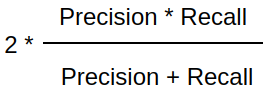

Notese que para conseguir un valor de F1 alto, necesariamente la precision y el recall tienen que ser altos y estar balanceados.

Buscamos los mejores hiperparámetros usando Random Search



In [336]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(5,10)),
               'min_samples_split': list(range(5,10)),
               'max_depth':[6]}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Cantidad de iteraciones
n = 10

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

Verificamos si podemos encontrar mejores hiperparametros con Grid Search

In [337]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(5,10)),
               'min_samples_split':list(range(5,10)),
               'max_depth':[6]}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
gridcv = GridSearchCV(estimator=base_tree,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv)

#Busco los hiperparamtros que optimizan F1 Score
gridcv.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(gridcv.best_params_)
#Mejor métrica
print(gridcv.best_score_)

Nos quedamos con los hiperparametros encontrados por Random Search ya que dio un mejor resultado

Entrenamiento con cross validation y mejores hiperparametros

In [338]:
# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=10) 
 
#Creo árbol con los mejores hiperparámetros 
arbolcv=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Selecciono métrica F1-Score
scorer_fn = make_scorer(f1_score)

#Hago CV
resultados = cross_validate(arbolcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

metricsCV=resultados['test_score']
mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

metricsCV

Mostramos la información sobre el árbol con mejor performance.

Graficamos del arbol con mejor performance (falta el grafico que no me deja compilar)

In [339]:
!pip install pydotplus

In [340]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(mejor_performance, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features.columns,
                class_names=['Cancelled','Not cancelled'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

A continuación veremos la performance del árbol, para ello calcularemos la F1 y mostraremos la matriz de confusión tanto para el set de entrenamiento como para el de testeo.

Predicción sobre el set de training

In [341]:
#Hago predicción sobre el set de evaluacion
y_pred= mejor_performance.predict(x_train)

print('F1-Score: {}'.format(f1_score(y_train, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_train,y_pred)
sns.heatmap(cm, cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Predicción sobre el set de testing

In [342]:
#Hago predicción sobre el set de evaluacion
y_pred= mejor_performance.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Random Forest con mejores hiperparametros

Busqueda de los mejores hiperparametros, usando Random Search

In [343]:
#Conjunto de parámetros que quiero usar
param_grid = {'n_estimators': [5,10,15,20], 
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [1,2,3,4,5], 
              'min_samples_split': list(range(2,10)), 
              'min_samples_leaf': list(range(1,10))
             } 

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
forest = RandomForestClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Cantidad de iteraciones
n = 10

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=forest,
                              param_distributions = param_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

Con Grid Search revisamos en detalle si podemos conseguir mejores hiperparametros

In [344]:
#Conjunto de parámetros que quiero usar
params_grid = {'n_estimators': [5,10,15], 
              'max_features': ['auto'], 
              'max_depth': [5], 
              'min_samples_split': list(range(5,10)), 
              'min_samples_leaf': list(range(5,10))
             }

#Cantidad de splits para el Cross Validation
folds=3

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
forest = RandomForestClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
gridcv = GridSearchCV(estimator=forest,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv)

#Busco los hiperparamtros que optimizan F1 Score
gridcv.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(gridcv.best_params_)
#Mejor métrica
print(gridcv.best_score_)

Nos quedamos con los hiperparametros hallados con Grid Search, que mejoran un poco la metrica

In [345]:
# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=10) 
 
#Creo árbol con los mejores hiperparámetros 
forestcv=RandomForestClassifier().set_params(**gridcv.best_params_)

#Selecciono métrica F1-Score
scorer_fn = make_scorer(f1_score)

#Hago CV
resultados = cross_validate(forestcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

metricsCV=resultados['test_score']
mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

metricsCV

Arbol con mejor performance

In [346]:
dot_data = StringIO()
export_graphviz(mejor_performance.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features.columns,
                class_names=['1', '0'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

A continuación veremos la performance del modelo, para ello calcularemos la F1 y mostraremos la matriz de confusión tanto para el set de entrenamiento como para el de testeo.

Sobre el set de training

In [347]:
y_pred= mejor_performance.predict(x_train)

print('F1-Score: {}'.format(f1_score(y_train, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_train,y_pred)
sns.heatmap(cm, cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Sobre el set de testeo

In [348]:
y_pred= mejor_performance.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Conclusiones

A continuación ponemos en una tabla los resultados del cálculo de la F1 sobre la predicción de los modelos tanto sobre el set de prueba como para el de entrenamiento, obteniendo como resultado final una mejor predicción con el árbol de desición que con Random Forest.

|                       	| _Entrenamiento_    	| _Prueba_           	|
|-----------------------	|--------------------	|--------------------	|
| **Árbol de desición** 	| 0.7454732347592313 	| 0.7386750788643532 	|
| **Random forest**     	| 0.5644429393836775 	| 0.5661870503597123 	|
